In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime
import seaborn as sns



In [33]:
import dwave
from dwave.cloud import Client
client = Client.from_config(config_file= '/home/rajarsi/.config/dwave/dwave.conf' )
dwave.cloud.config.load_config(['/home/rajarsi/.config/dwave/dwave.conf'])
import dimod
from dwave.system import LeapHybridCQMSampler
from dimod import BinaryQuadraticModel as BQM
from dimod import ConstrainedQuadraticModel as CQM


In [25]:
## define bqm ~
bqm = BQM({'x':2, 'y':-1,'z':1},{ ('x','y'):-1, ('x','z'): -2, ('y','z'): 1}, 0 , 'SPIN')
bqm


BinaryQuadraticModel({'x': 2.0, 'y': -1.0, 'z': 1.0}, {('y', 'x'): -1.0, ('z', 'x'): -2.0, ('z', 'y'): 1.0}, 0.0, 'SPIN')

In [31]:
## convert to CQM and add constraints ~
cqm = CQM.from_bqm(bqm)
cqm.add_constraint_from_iterable([('x','z',2), ('x',1), ('y', -1), ('y','z', 1) ], '<=', rhs= 3 , label= 'c1')
cqm.constraints['c1'].to_polystring()
cqm.objective

QuadraticModel({'x': 2.0, 'y': -1.0, 'z': 1.0}, {('y', 'x'): -1.0, ('z', 'x'): -2.0, ('z', 'y'): 1.0}, 0.0, {'x': 'SPIN', 'y': 'SPIN', 'z': 'SPIN'}, dtype='float64')

In [27]:
sampler = LeapHybridCQMSampler()

In [28]:
sample_set = sampler.sample_cqm(cqm)

In [30]:
client.token

'DEV-fd78ff4f32e65052173b24a9c589ef23f0c3ef9b'

### Example: Portfolio Optmisation

In [41]:
def get_stock_data(stocks, start= datetime.datetime(2000,1,1) , end= datetime.datetime(2022,1,1) ) :
    """ Return stock data and covariace matrix corresponding to it """
    data = pd.DataFrame()
    for stock in stocks:
         data[stock] = pdr.DataReader(stock,data_source='yahoo', start= start, end= end)['Adj Close']

    rtrn_data = data/data.shift(1)
    rtrn_data =  np.log(rtrn_data[1:])
    cov_matrix = rtrn_data.cov()
    return rtrn_data, cov_matrix

In [96]:
stocks= ['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC']
data = get_stock_data(stocks)


In [107]:
cov_matrix = data[1]
mean_rtrn = data[0].mean()
for stock in stocks : cov_matrix[stock][stock] = 0

<AxesSubplot:>

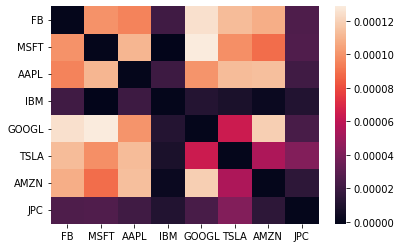

In [108]:
sns.heatmap(cov_matrix)

In [123]:
bqm = BQM('BINARY')
for stock in stocks : bqm.add_variable(stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: bqm.add_linear_from({stock: mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: bqm.add_quadratic_from({(stock_i, stock_j): cov_matrix[stock_i][stock_j] })
        
bqm

BinaryQuadraticModel({'FB': -0.0029954910451557323, 'MSFT': 0.001719171496094148, 'AAPL': 0.0020518090970164738, 'IBM': -0.0001770631482118617, 'GOOGL': 0.001335610520782981, 'TSLA': 0.003447893073304704, 'AMZN': -0.00024408770473346333, 'JPC': 7.843049184898439e-05}, {('MSFT', 'FB'): 0.0001994706525248358, ('AAPL', 'FB'): 0.00019033685672190987, ('AAPL', 'MSFT'): 0.00022135498613413843, ('IBM', 'FB'): 4.1837907154129646e-05, ('IBM', 'MSFT'): -2.1466874849729516e-06, ('IBM', 'AAPL'): 3.959752222432272e-05, ('GOOGL', 'FB'): 0.00024993190391848667, ('GOOGL', 'MSFT'): 0.00025730615761147883, ('GOOGL', 'AAPL'): 0.00020048003670505854, ('GOOGL', 'IBM'): 2.2710877276271583e-05, ('TSLA', 'FB'): 0.00022518633497902902, ('TSLA', 'MSFT'): 0.00019702645618484716, ('TSLA', 'AAPL'): 0.00022521635004316896, ('TSLA', 'IBM'): 1.6614124318029612e-05, ('TSLA', 'GOOGL'): 0.00012840917819114043, ('AMZN', 'FB'): 0.00021599180892110164, ('AMZN', 'MSFT'): 0.00017817140115657982, ('AMZN', 'AAPL'): 0.000226981

In [124]:
cqm = CQM.from_bqm(bqm)
list(cqm.variables)

['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC']

In [70]:
cqm.add_constraint_from_iterable(cqm.variables, '<=',  rhs= len(cov_matrix))

TypeError: cannot unpack non-iterable int object